<h1><font color="#113D68" size=5>TINTOlib: Converting Tidy Data into Image for Classification with Vision Transformer</font></h1>



<h1><font color="#113D68" size=6>How to read TINTO images</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
<font color="#113D68" size=3>Raúl García-Castro</font><br>
<font color="#113D68" size=3>Luis Orozco-Barbosa</font><br>
</div>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Index</font></h2>

* [0. Context](#section0)
* [1. Description](#section1)
    * [1.1. Main Features](#section12)
    * [1.2. Citation](#section12)
* [2. Libraries](#section2)
* [3. Data processing](#section3)
    * [3.1. Read images](#section31)
    * [3.2. Data Curation](#section32)
* [4. Pre-modelling phase](#section4)
    * [4.1. Resize images](#section41)
    * [4.2. Iteradores](#section42)
* [5. Modelling with CNN](#section5)
    * [5.1. CNN](#section51)
    * [5.2. Compile and fit](#section52)
    * [5.3. Results](#section53)

---
<a id="section0"></a>
# <font color="#004D7F" size=6> 0. Context</font>

This is a tutorial on how to read the images created by TINTOlib and pass them to a Vision Transformer (ViT). The images must already be created by the TINTOlib software. See the documentation in GITHUB for how to create the images from tabular data.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
See the paper from [Information Fusion Journal](https://doi.org/10.1016/j.inffus.2022.10.011)

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
See the paper from [SoftwareX](https://doi.org/10.1016/j.softx.2023.101391)

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
You can see all information about TINTO in [GitHub](https://github.com/oeg-upm/TINTO)

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section1"></a>
# <font color="#004D7F" size=6> 1. Description</font>

The growing interest in the use of algorithms-based machine learning for predictive tasks has generated a large and diverse development of algorithms. However, it is widely known that not all of these algorithms are adapted to efficient solutions in certain tidy data format datasets. For this reason, novel techniques are currently being developed to convert tidy data into images with the aim of using Convolutional Neural Networks (CNNs)  or Vision Transformer (ViT). TINTO offers the opportunity to convert tidy data into images through the representation of characteristic pixels by implementing two dimensional reduction algorithms: PCA and _t_-SNE. Our proposal also includes a blurring technique, which adds more ordered information to the image and can improve the classification task in CNNs.

---
<a id="section11"></a>
# <font color="#004D7F" size=5> 1.1. Main Features</font>

- Supports all CSV data in **[Tidy Data](https://www.jstatsoft.org/article/view/v059i10)** format.
- For now, the algorithm converts tabular data for binary and multi-class classification problems into machine learning.
- Input data formats:
    - **Tabular files**: The input data must be in **[CSV](https://en.wikipedia.org/wiki/Comma-separated_values)**, taking into account the **[Tidy Data](https://www.jstatsoft.org/article/view/v059i10)** format.
    - **Tidy Data**: The **target** (variable to be predicted) should be set as the last column of the dataset. Therefore, the first columns will be the features.
    - All data must be in numerical form. TINTO does not accept data in string or any other non-numeric format.
- Two dimensionality reduction algorithms are used in image creation, **[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)** and **[*t*-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)** from the Scikit-learn Python library.
- The synthetic images to be created will be in black and white, i.e. in 1 channel.
- The synthetic image **dimensions** can be set as a parameter when creating them.
- The synthetic images can be created using **characteristic pixels** or **blurring** painting technique (expressing an overlap of pixels as the **maximum** or **average**).
- Runs on **Linux**, **Windows** and **macOS** systems.
- Compatible with **[Python](https://www.python.org/)** 3.7 or higher.

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section2"></a>
# <font color="#004D7F" size=6> 2. Libraries</font>

Adding parent directory to import module residing outside this notebook folder

In [1]:
import sys
sys.path.append('../')

The first thing we need to do is to declare the libraries

In [2]:
import gc
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf
import tifffile as tifi
import keras
from keras import ops
from PIL import Image
from sklearn.metrics import (mean_absolute_error, mean_absolute_percentage_error,
                             mean_squared_error, r2_score)
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler

# TensorFlow and Keras
from keras import layers, models, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (Activation, BatchNormalization, concatenate,
                                     Conv2D, Dense, Dropout, Flatten, Input,
                                     LayerNormalization, MaxPool2D, MaxPooling2D)
from keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adadelta, Adam, Adamax, SGD

# TINTOlib Models
from TINTOlib.barGraph import BarGraph
from TINTOlib.combination import Combination
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.supertml import SuperTML
from TINTOlib.tinto import TINTO

# Set the backend for Keras
os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

C:\Users\jiayu\AppData\Local\Temp\ipykernel_38660\810579034.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section3"></a>
# <font color="#004D7F" size=6> 3. Data processing</font>

The first thing to do is to read all the images created by TINTO. TINTO creates a folder which contains subfolders corresponding to each target that has the problem. Each image corresponds to a sample of the original dataset.

<a id="section31"></a>
# <font color="#004D7F" size=5> 3.1. Create images with TINTOlib</font>

In [3]:
# Select the model and the parameters
problem_type = "supervised"
size = 20
image_model = TINTO(problem=problem_type,verbose=True,blur=True,pixels=size)

# Define the dataset path and the folder where the images will be saved
dataset_path = "../Datasets/covtype.csv"
images_folder = "../HyNNImages/Classification/images_covtype_TINTO"

Normalize dataset

In [4]:
df = pd.read_csv(dataset_path)
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5


In [5]:
# Select all the attributes to normalize
columns_to_normalize = df.columns[:-1]


# Normalize between 0 and 1
df_normalized = (df[columns_to_normalize] - df[columns_to_normalize].min()) / (df[columns_to_normalize].max() - df[columns_to_normalize].min())

# Combine the attributes and the label
df_normalized = pd.concat([df_normalized, df[df.columns[-1]]], axis=1)

df_normalized.head(2)


,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,0.368684,0.141667,0.045455,0.184681,0.223514,0.071659,0.870079,0.913386,0.582677,0.875366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.365683,0.155556,0.030303,0.151754,0.215762,0.054798,0.866142,0.925197,0.594488,0.867838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [6]:
import os

# Generate the images if the folder does not exist
if not os.path.exists(images_folder):
    #Generate thet images
    image_model.generateImages(df, images_folder)
else:
    print("The images are already generated")

img_paths = os.path.join(images_folder,problem_type+".csv")

print(img_paths)

The images are already generated
../HyNNImages/Classification/images_covtype_TINTO\supervised.csv


<a id="section32"></a>
# <font color="#004D7F" size=5> 3.2. Data Analysis</font>

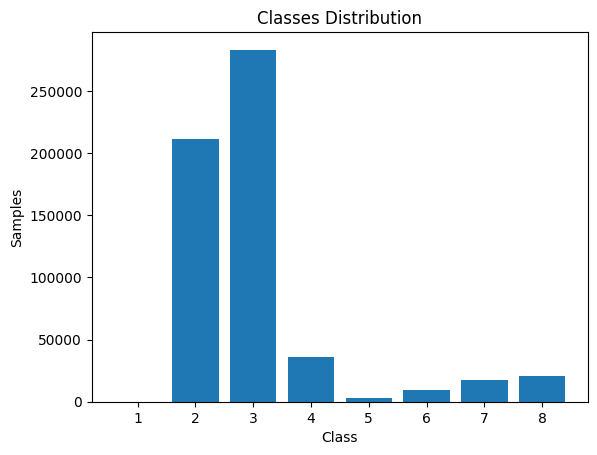

In [7]:
target_values = df_normalized.iloc[:,-1]
class_counts = np.bincount(target_values)
class_labels = np.arange(1, len(class_counts) + 1)

# Create the bar plot
plt.bar(class_labels, class_counts)

# Customize the plot
plt.xlabel('Class')
plt.ylabel('Samples')
plt.title('Classes Distribution')

# Display the plot
plt.show()

<a id="section33"></a>
# <font color="#004D7F" size=5> 3.3. Read images</font>

In [8]:
imgs = pd.read_csv(img_paths)

#imgs["images"]= images_folder + "\\" + imgs["images"]
imgs["images"]= images_folder + "/" + imgs["images"]

combined_dataset = pd.concat([imgs,df_normalized[columns_to_normalize]],axis=1)
combined_dataset

df_x = combined_dataset.drop("class",axis=1)
df_y = combined_dataset["class"].replace(-1, 0)

df_x.head(2)

,images,0,1,2,3,4,5,6,7,8,...,44,45,46,47,48,49,50,51,52,53
0,../HyNNImages/Classification/images_covtype_TI...,0.368684,0.141667,0.045455,0.184681,0.223514,0.071659,0.870079,0.913386,0.582677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,../HyNNImages/Classification/images_covtype_TI...,0.365683,0.155556,0.030303,0.151754,0.215762,0.054798,0.866142,0.925197,0.594488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section4"></a>
# <font color="#004D7F" size=6> 4. Pre-modelling phase</font>

In [9]:
import cv2
X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size = 0.40, random_state = 123,stratify=df_y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state = 123, stratify=y_val)

X_train_num = X_train.drop("images",axis=1)
X_val_num = X_val.drop("images",axis=1)
X_test_num = X_test.drop("images",axis=1)

X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

"""X_train_img = np.array([cv2.resize(cv2.imread(img),(60,60)) for img in X_train["images"]])
X_val_img = np.array([cv2.resize(cv2.imread(img),(60,60)) for img in X_val["images"]])
X_test_img = np.array([cv2.resize(cv2.imread(img),(60,60)) for img in X_test["images"]])"""

n_class = df['Species'].value_counts().count()

attributes = len(X_train_num.columns)
input_shape = X_train_img[0].shape

print("Images shape: ", input_shape)
print("Attributres: ",attributes)
pixels=X_train_img[0].shape[0]
print("Image size (pixels):", pixels)

KeyboardInterrupt: 

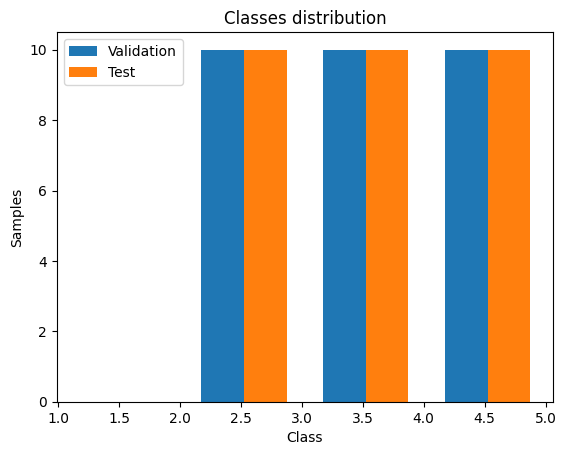

In [ ]:
#SPLITS CLASS DISTRIBUTION

train_class_counts = np.bincount(y_train)
val_class_counts = np.bincount(y_val)
test_class_counts = np.bincount(y_test)

width = 0.35 
#plt.bar(class_labels, train_class_counts, width, label='Train')
plt.bar(class_labels + width, val_class_counts, width, label='Validation')
plt.bar(class_labels + width*2, test_class_counts, width, label='Test')

plt.xlabel('Class')
plt.ylabel('Samples')
plt.title('Classes distribution')
#plt.xticks(class_labels + width / 2, class_labels)
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
#ONE HOT ENCODING FOR MULTICLASS PROBLEMS
from tensorflow.keras.utils import to_categorical

# y-1 because target is between [1,28] and not [0,27]
y_train_oh =  to_categorical(y_train-1,n_class)
y_val_oh = to_categorical(y_val-1,n_class)
y_test_oh = to_categorical(y_test-1,n_class)

In [ ]:
y_val

144    3.0
125    3.0
100    3.0
43     1.0
91     2.0
72     2.0
17     1.0
61     2.0
63     2.0
116    3.0
51     2.0
32     1.0
14     1.0
4      1.0
38     1.0
146    3.0
37     1.0
129    3.0
19     1.0
101    3.0
56     2.0
16     1.0
105    3.0
70     2.0
138    3.0
80     2.0
74     2.0
67     2.0
45     1.0
117    3.0
Name: class, dtype: float64

In [ ]:
y_val_oh[0]

array([0., 0., 1.])

<a id="section5"></a>
# <font color="#004D7F" size=6> 5. Modeling hybrid network</font>

---
<a id="section51"></a>
# <font color="#004D7F" size=5> 5.1. FFNN for tabular data</font>

This is an example of a simple FFNN for tabular data. Note that we are not looking for the optimization of the ViT but to show an example of TINTOlib execution.

In [ ]:
dropout = 0.1

In [ ]:
filters_ffnn = [64,32,16]

ff_model = keras.Sequential()
ff_model.add(keras.Input(shape=(attributes,)))

for layer in filters_ffnn:
    ff_model.add(layers.Dense(layer, activation="gelu"))
    ff_model.add(Dropout(dropout))

In [ ]:
ff_model(keras.Input(shape=(attributes,)))

<KerasTensor shape=(None, 16), dtype=float32, sparse=False, name=keras_tensor_355>

---
<a id="section52"></a>
# <font color="#004D7F" size=5> 5.2. ViT for TINTOlib images</font>

This is an example of a simple ViT for TINTOlib images. Note that we are not looking for the optimization of the ViT but to show an example of TINTOlib execution.

It is crucial to select an appropriate patch size. The patch size should be a divisor of the input image size; for example, an image of 20x20 with a patch size of 5 would result in a total of 16 patches (4x4 grid). Given the high computational cost, the patch size should be carefully chosen based on the dimensions of the image.

Este código define los hiperparámetros para el modelo ViT implementado en TensorFlow y Keras. Los hiperparámetros son los siguientes:

* `learning_rate`: tasa de aprendizaje para el optimizador.
* `weight_decay`: valor de decaimiento de peso para regularización L2.
* `batch_size`: tamaño del lote de entrenamiento.
* `num_epochs`: número de épocas de entrenamiento.
* `image_size`: tamaño de las imágenes de entrada.
* `patch_size`: tamaño de los parches extraídos de las imágenes.
* `num_patches`: número total de parches extraídos de cada imagen.
* `projection_dim`: dimensión de la proyección lineal para los parches.
* `num_heads`: número de cabezas de atención en el transformador.
* `transformer_units`: lista de unidades en las capas del transformador.
* `transformer_layers`: número de capas en el transformador.
* `mlp_head_units`: lista de unidades en las capas densas del clasificador final.

Estos hiperparámetros se utilizan para configurar el modelo ViT y su proceso de entrenamiento.

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 20  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    1024,
    512,
    16
]  # Size of the dense layers of the final classifier

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    print(inputs.shape)

    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=features)
    return model

In [ ]:
vit_model = create_vit_classifier()

(None, 20, 20, 3)


---
<a id="section53"></a>
# <font color="#004D7F" size=5> 5.3. Concatenate branches</font>

Finally, we must concatenate the output of the CNN branch with the output of the FFNN branch in a final FFNN that will give the predictions.

In [ ]:
# Combine the outputs
combined_output = layers.concatenate([ff_model.output, vit_model.output])
x = Dense(32, activation="relu")(combined_output)

x = Dense(n_class, activation="softmax")(x)
model = Model(inputs=[ff_model.input, vit_model.input], outputs=x)

In [ ]:
ff_model.output

<KerasTensor shape=(None, 16), dtype=float32, sparse=False, name=keras_tensor_355>

In [ ]:
vit_model.output

<KerasTensor shape=(None, 16), dtype=float32, sparse=False, name=keras_tensor_440>

---
<a id="section54"></a>
# <font color="#004D7F" size=5> 5.4. Metrics</font>

Define metrics and some hyperparameters

In [150]:
METRICS = [
    #tf.keras.metrics.TruePositives(name = 'tp'),
    #tf.keras.metrics.FalsePositives(name = 'fp'),
    #tf.keras.metrics.TrueNegatives(name = 'tn'),
    #tf.keras.metrics.FalseNegatives(name = 'fn'), 
    tf.keras.metrics.CategoricalAccuracy(name ='accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall'),
    tf.keras.metrics.AUC(name = 'auc'),
]

Print the hybrid model

In [151]:
from keras.utils import plot_model
model.summary()
plot_model(model)

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 20, 20, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_3 (Patches) │ (None, 9, 108)    │          0 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_3     │ (None, 9, 64)     │      7,552 │ patches_3[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 9, 64)     │        128 │ patch_encoder_3[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 9, 64)     │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_48 (Add)        │ (None, 9, 64)     │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 9, 64)     │        128 │ add_48[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_77 (Dense)    │ (None, 9, 128)    │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_95          │ (None, 9, 128)    │          0 │ dense_77[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_78 (Dense)    │ (None, 9, 64)     │      8,256 │ dropout_95[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_96          │ (None, 9, 64)     │          0 │ dense_78[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_49 (Add)        │ (None, 9, 64)     │          0 │ dropout_96[0][0], │
│                     │                   │            │ add_48[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 9, 64)     │        128 │ add_49[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 9, 64)     │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_50 (Add)        │ (None, 9, 64)     │          0 │ multi_head_atten… │
│                     │                   │            │ add_49[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 9, 64)     │        128 │ add_50[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_79 (Dense)    │ (None, 9, 128)    │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_98          │ (None, 9, 128)    │          0 │ dense_79[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 1,801,219 (6.87 MB)

 Trainable params: 1,801,219 (6.87 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


---
<a id="section55"></a>
# <font color="#004D7F" size=5> 5.5. Compile and fit</font>

Note to specify the **loss depending** on whether you have a binary or multiclass classification problem.

In [152]:
#HYPERPARAMETERS
opt = Adam(learning_rate=1e-3)
model.compile(
    loss="categorical_crossentropy", 
    optimizer=opt,
    metrics = METRICS
)
epochs = 500

In [153]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode="min" ,restore_best_weights=True)

In [154]:
model_history=model.fit(
    x=[X_train_num, X_train_img/255], y=y_train_oh,
    validation_data=([X_val_num, X_val_img/255], y_val_oh),
    epochs=epochs , 
    batch_size=8,
    callbacks=[early_stopping]
    #steps_per_epoch = X_train_num.shape[0]//batch_size,
    #validation_steps = X_train_num.shape[0]//batch_size,
    #callbacks=[early_stopping]
)

Epoch 1/500


12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.3529 - auc: 0.5339 - loss: 1.2614 - precision: 0.3342 - recall: 0.1875 - val_accuracy: 0.3667 - val_auc: 0.7100 - val_loss: 1.0811 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3357 - auc: 0.4804 - loss: 1.1930 - precision: 0.2288 - recall: 0.0435 - val_accuracy: 0.6667 - val_auc: 0.7506 - val_loss: 1.0620 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5378 - auc: 0.6571 - loss: 1.0783 - precision: 0.4493 - recall: 0.0467 - val_accuracy: 0.6333 - val_auc: 0.7894 - val_loss: 1.0248 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4754 - auc: 0.5844 - loss: 1.2232 - precision: 0.2295 - recall: 0.0107 - val_accuracy: 0.6667 - val_auc: 0.9297 - val_loss: 0.9881 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50

In [155]:
print(model_history.history.keys())

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


<a id="section6"></a>
# <font color="#004D7F" size=6> 6. Results</font>

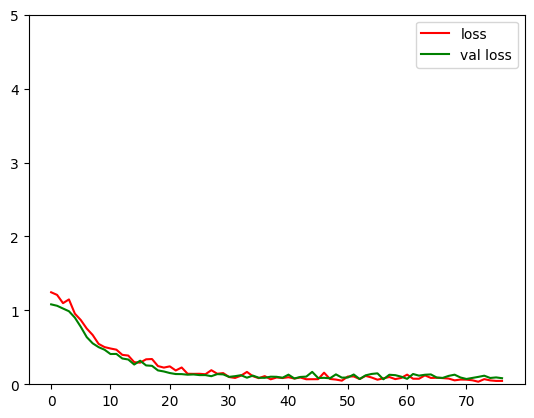

In [156]:
#print(model_history.history['loss'])
plt.plot(model_history.history['loss'], color = 'red', label = 'loss')
plt.plot(model_history.history['val_loss'], color = 'green', label = 'val loss')
plt.legend(loc = 'upper right')
plt.ylim(0,5)
plt.show()

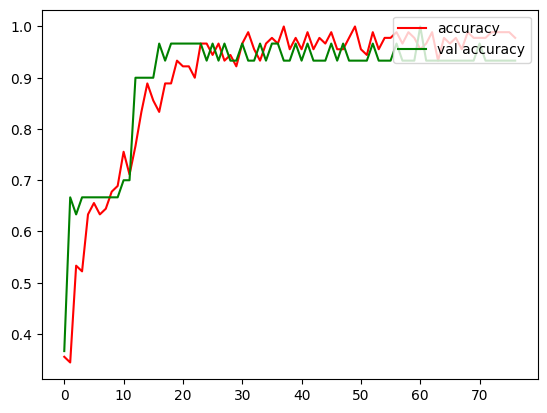

In [157]:
plt.plot(model_history.history['accuracy'], color = 'red', label = 'accuracy')
plt.plot(model_history.history['val_accuracy'], color = 'green', label = 'val accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [158]:
prediction = model.predict([X_test_num,X_test_img/255],)
real_values= y_test.values-1
predicted_classes = np.argmax(prediction, axis = 1)

result = [list(t) for t in zip(predicted_classes, real_values)]
#print(np.round(prediction))
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
[[0, 0.0], [0, 0.0], [1, 1.0], [0, 0.0], [1, 1.0], [2, 2.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [1, 1.0], [2, 1.0], [1, 1.0], [2, 2.0], [1, 1.0], [2, 2.0], [2, 2.0], [0, 0.0], [2, 2.0], [2, 2.0], [2, 2.0], [0, 0.0], [0, 0.0], [0, 0.0], [2, 2.0], [1, 1.0], [2, 2.0], [0, 0.0], [2, 2.0], [1, 1.0]]


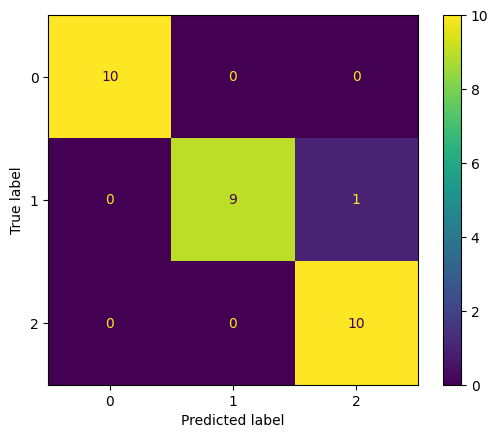

In [159]:
from sklearn.metrics import confusion_matrix
true_classes = real_values

cm = confusion_matrix(true_classes, predicted_classes)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()




In [160]:
report = sklearn.metrics.classification_report(true_classes, 
                                               predicted_classes)
print(report) 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      0.90      0.95        10
         2.0       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [161]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score, recall_score

test_accuracy = accuracy_score(true_classes, predicted_classes)
#test_auc = roc_auc_score(true_classes, predicted_classes)
#test_precision = precision_score(true_classes, predicted_classes)
#test_recall = recall_score(true_classes, predicted_classes)

print("Test accuracy:",test_accuracy)
#print("Test AUC:",test_auc)
#print("Test precision:",test_precision)
#print("Test recall:",test_recall)

Test accuracy: 0.9666666666666667


In [162]:
train_accuracy = model_history.history["accuracy"][-1]
train_auc = model_history.history["auc"][-1]
train_precision = model_history.history["precision"][-1]
train_recall = model_history.history["recall"][-1]
train_loss = model_history.history["loss"][-1]

print("Train accuracy:",train_accuracy)
print("Train AUC:",train_auc)
print("Train precision:",train_precision)
print("Train recall:",train_recall)
print("Train loss:",train_loss)

Train accuracy: 0.9777777791023254
Train AUC: 0.9997531175613403
Train precision: 0.9777777791023254
Train recall: 0.9777777791023254
Train loss: 0.04577755928039551


In [163]:
validation_accuracy = model_history.history["val_accuracy"][-1]
validation_auc = model_history.history["val_auc"][-1]
validation_precision = model_history.history["val_precision"][-1]
validation_recall = model_history.history["val_recall"][-1]
validation_loss = model_history.history["val_loss"][-1]

print("Validation accuracy:",validation_accuracy)
print("Validation AUC:",validation_auc)
print("Validation precision:",validation_precision)
print("Validation recall:",validation_recall)
print("Validation loss:",validation_loss)

Validation accuracy: 0.9333333373069763
Validation AUC: 0.9977777600288391
Validation precision: 0.9333333373069763
Validation recall: 0.9333333373069763
Validation loss: 0.08218786120414734


In [164]:
################ ????? ################
import csv

experiments_csv = "C:\\Users\\Borja\\EXP_TINTOLIB\\Classification\\Classification_Cancer.csv"
model_name = "TINTO1000"
preprocess = "TINTO"

FFNN = str(filters_ffnn)
CNN = str(filters_cnn)
BIAS = (1-train_accuracy-0.05)
VARIANCE = (1-train_accuracy)-(1-validation_accuracy)
metrics = [model_name,preprocess,epochs,FFNN,CNN,test_accuracy,test_auc,test_precision,test_recall,BIAS,VARIANCE,
           train_accuracy,train_auc,train_precision,train_recall,train_loss,
           validation_accuracy,validation_auc,validation_precision,validation_recall,validation_loss]
print(metrics)


NameError: name 'filters_cnn' is not defined

In [ ]:
with open(experiments_csv, 'a', newline='') as archivo:
    escritor_csv = csv.writer(archivo)
    escritor_csv.writerow(metrics)